In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data = pd.read_csv('/content/FinancialMarketData.xlsx - EWS.csv')


In [6]:
data.describe()

,Y,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,GT10,USGG2YR,USGG3M,US0001M,GTDEM30Y,GTDEM10Y,GTDEM2Y,EONIA,GTITL30YR,GTITL10YR,GTITL2YR,GTJPY30YR,GTJPY10YR,GTJPY2YR,GTGBP30Y,GTGBP20Y,GTGBP2Y,LUMSTRUU,LMBITR,LUACTRUU,LF98TRUU,LG30TRUU,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,0.213321,987.463744,0.036153,2259.860486,245.247670,90.934982,106.605734,1.569661,60.708101,19.992169,3.908361,3.266748,1.990379,1.575180,1.836137,3.039282,2.448365,1.431110,1.363676,4.426725,3.680791,2.104911,1.724494,0.904126,0.150180,3.450157,3.445772,2.299772,1637.293510,883.615477,2077.306949,1231.258119,804.720667,232.109985,704.379545,259.052717,1606.997102,107.877138,784.846292,1903.216436,648.681377,693.156616,53.933159
std,0.409837,494.623740,0.349453,2017.811888,68.278066,11.379095,12.840754,0.212344,25.900813,8.642157,1.178584,1.332464,1.710305,1.802895,1.909024,1.779526,1.851558,1.876061,1.721894,1.274729,1.465289,1.700726,0.720026,0.643985,0.297519,1.263211,1.366181,2.128524,417.229338,241.507115,690.731794,553.121000,370.251989,109.917628,309.951757,75.934451,698.481956,20.795973,200.076443,986.468254,299.096020,405.527014,24.738356
min,0.000000,256.680000,-0.974000,291.000000,106.293000,71.329000,75.940000,1.172000,10.010000,9.430000,1.163000,0.508000,0.107300,-0.038000,0.105750,-0.471000,-0.794000,-0.968000,-0.498000,1.386000,0.512000,-0.458000,0.056000,-0.291000,-0.351000,0.547000,0.489200,-0.163300,869.330000,472.723000,986.940000,491.080000,294.367000,80.797000,230.527000,121.331000,663.690000,56.300000,431.710000,280.500000,151.250000,112.600000,13.460000
25%,0.000000,433.740000,-0.191000,990.000000,184.705550,81.240500,101.565000,1.418000,39.625000,13.640000,2.960000,2.195500,0.576000,0.090000,0.241000,1.288000,0.539000,-0.382500,-0.229500,3.395000,2.329500,0.403500,1.055000,0.253500,-0.031000,2.336000,2.185000,0.466000,1251.130000,683.896500,1509.730000,743.535000,479.388500,131.025000,434.661000,205.315500,1103.925000,90.605000,601.615000,1042.645000,463.195000,278.385000,28.565000
50%,0.000000,1137.800000,0.035000,1518.000000,234.560000,89.716000,108.720000,1.562000,57.400000,17.980000,4.100000,3.115000,1.522000,0.958000,1.214000,3.572000,2.994000,1.057000,0.437000,4.839000,4.098000,2.214000,1.944000,1.038000,0.097000,4.112000,4.114000,0.936000,1723.800000,855.517000,2045.550000,1145.150000,765.248000,213.205000,714.807000,264.770000,1324.430000,111.320000,786.830000,1860.960000,612.930000,691.530000,58.740000
75%,0.000000,1324.825000,0.260500,2685.500000,301.539500,97.404000,116.220000,1.677500,79.640000,23.625000,4.844500,4.345000,2.927500,2.335500,2.502500,4.582500,4.080000,3.121000,2.890000,5.312500,4.683500,3.523000,2.315500,1.429500,0.230000,4.486000,4.611000,4.488000,2005.330000,1099.705500,2624.980000,1663.945000,1111.224500,342.884500,939.824500,320.753000,1992.445000,126.470000,965.875000,2533.770000,793.620000,1014.750000,68.460000
max,1.000000,2006.910000,0.991000,11793.000000,467.570000,119.820000,134.630000,2.085000,140.970000,75.910000,6.747000,6.748000,6.872000,6.414000,6.776000,6.254000,5.644000,5.264000,5.730000,7.500000,7.209000,7.015000,3.128000,1.968000,1.080000,5.075000,5.242000,6.613000,2325.860000,1350.500000,3550.430000,2378.530000,1525.790000,431.552800,1286.353000,398.706500,4043.690000,146.390000,1210.580000,4721.360000,1617.640000,1730.510000,129.200000


In [7]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = data[numerical_features]

In [65]:
data['Y'].value_counts()

,count
Y,
0,874
1,237


In [67]:
df = data[data['Y']==0][0:300]

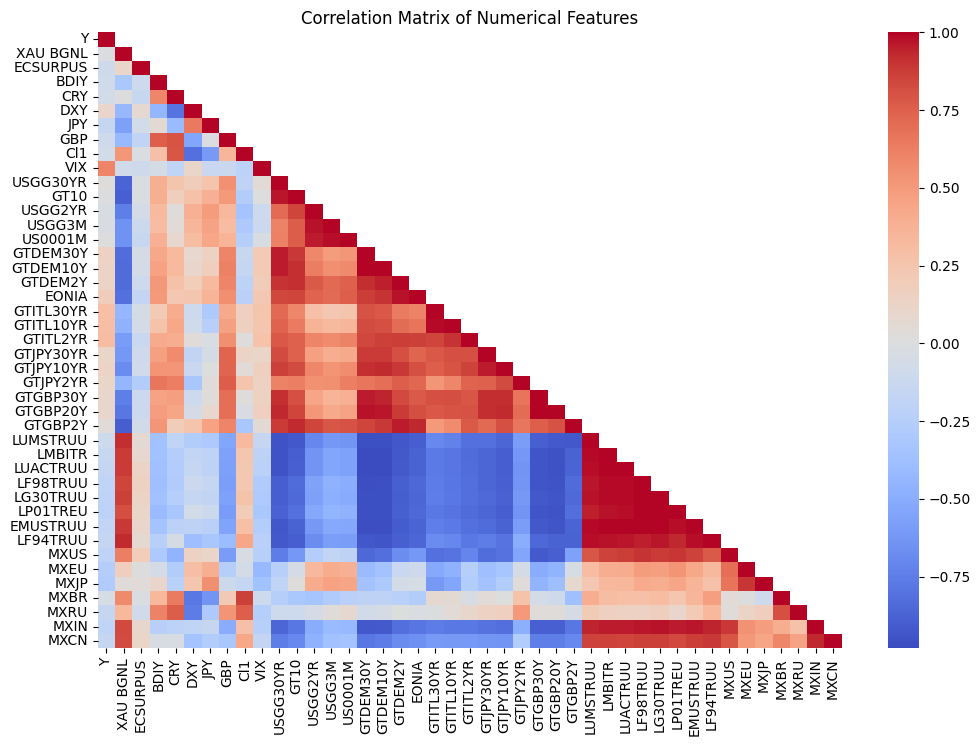

In [11]:
correlation_matrix = numerical_data.corr()

upper_triangle = np.triu(correlation_matrix)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix), k=1)

# Set the plot size for better readability
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', cbar=True)

# Set a title for the heatmap
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [85]:
# Splitting data

data['Data'] = pd.to_datetime(data['Data'], format='%m/%d/%Y')

selected_features = ['VIX', 'BDIY', 'ECSURPUS', 'JPY', 'Cl1']

train_data = data[data['Data'] < '04/01/2016']
test_data = data[data['Data'] >= '04/01/2016']

X_train = train_data[selected_features]
y_train = train_data['Y']

X_test = test_data[selected_features]
y_test = test_data['Y']


In [86]:
train_data.shape, test_data.shape

((847, 44), (264, 44))

Logistic Regresssion

In [87]:
# Initialize the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.92


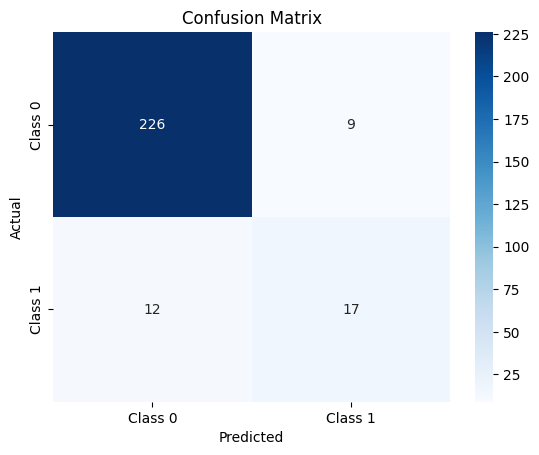

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       235
           1       0.65      0.59      0.62        29

    accuracy                           0.92       264
   macro avg       0.80      0.77      0.79       264
weighted avg       0.92      0.92      0.92       264



In [88]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Class imbalance is significant in the data. Also, since not detecting anomalies are extremely expensive, recall is extremely important for this data

## XGBOOST

In [49]:
!pip install xgboost
!pip install shap

In [89]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from xgboost.callback import EarlyStopping

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Loss metric
    use_label_encoder=False,     # Disable label encoding
    scale_pos_weight=10,         # Handle class imbalance
    random_state=42
)


# Fit the model
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Predict
y_pred = xgb_model.predict(X_test)
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate recall
print(classification_report(y_test, y_pred))


[0]	validation_0-logloss:0.78399
[1]	validation_0-logloss:0.61667
[2]	validation_0-logloss:0.54066
[3]	validation_0-logloss:0.45644
[4]	validation_0-logloss:0.40064
[5]	validation_0-logloss:0.36809
[6]	validation_0-logloss:0.33665
[7]	validation_0-logloss:0.32944
[8]	validation_0-logloss:0.32267
[9]	validation_0-logloss:0.31868
[10]	validation_0-logloss:0.31987
[11]	validation_0-logloss:0.31497
[12]	validation_0-logloss:0.31198
[13]	validation_0-logloss:0.28319
[14]	validation_0-logloss:0.27838
[15]	validation_0-logloss:0.28669
[16]	validation_0-logloss:0.26921
[17]	validation_0-logloss:0.27330
[18]	validation_0-logloss:0.27072
[19]	validation_0-logloss:0.27860
[20]	validation_0-logloss:0.27697
[21]	validation_0-logloss:0.27228
[22]	validation_0-logloss:0.26855
[23]	validation_0-logloss:0.27231
[24]	validation_0-logloss:0.27421
[25]	validation_0-logloss:0.27532


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:10:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.27140
[27]	validation_0-logloss:0.27228
[28]	validation_0-logloss:0.27189
[29]	validation_0-logloss:0.27011
[30]	validation_0-logloss:0.26707
[31]	validation_0-logloss:0.26790
[32]	validation_0-logloss:0.26345
[33]	validation_0-logloss:0.26377
[34]	validation_0-logloss:0.26383
[35]	validation_0-logloss:0.26357
[36]	validation_0-logloss:0.26310
[37]	validation_0-logloss:0.26447
[38]	validation_0-logloss:0.26078
[39]	validation_0-logloss:0.25547
[40]	validation_0-logloss:0.25583
[41]	validation_0-logloss:0.25620
[42]	validation_0-logloss:0.25128
[43]	validation_0-logloss:0.25549
[44]	validation_0-logloss:0.25564
[45]	validation_0-logloss:0.25533
[46]	validation_0-logloss:0.25712
[47]	validation_0-logloss:0.26058
[48]	validation_0-logloss:0.26455
[49]	validation_0-logloss:0.26444
[50]	validation_0-logloss:0.25807
[51]	validation_0-logloss:0.26110
[52]	validation_0-logloss:0.26139
[53]	validation_0-logloss:0.26058
[54]	validation_0-logloss:0.26042
[55]	validatio

Recall for both classes increased significantly. XGBoost performs well over the data

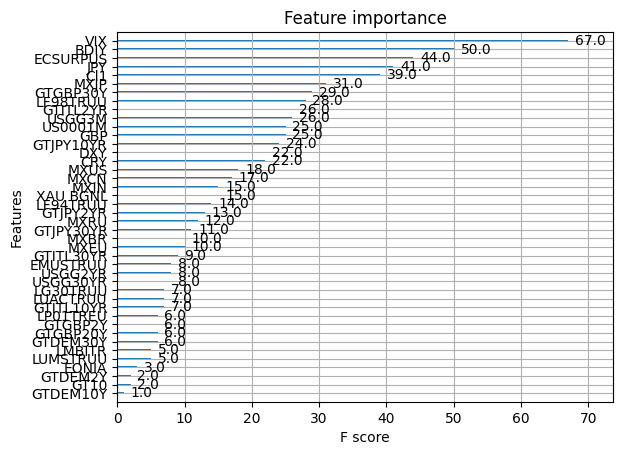

In [46]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, importance_type='weight')
plt.show()

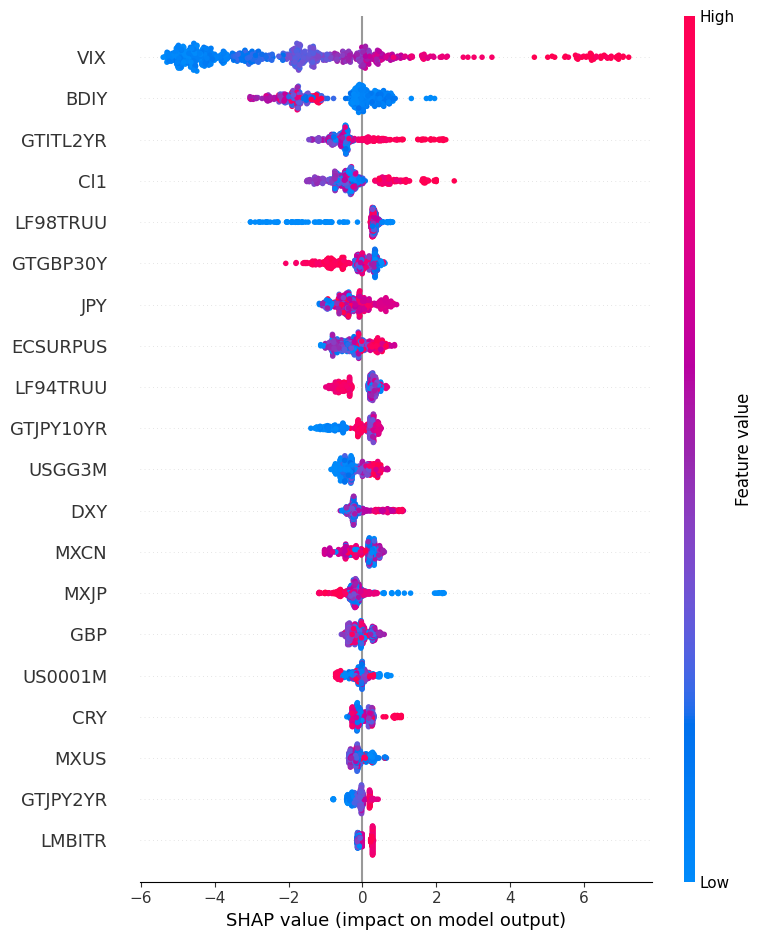

In [52]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

The spread of SHAP values for each feature indicates how much it affects different predictions.

VIX - Volatility Index - As expected, highly influences the prediction.

BDIY - Shipping index - Signifies how massively shipping industry is affected by anomalies.

ECSURPUS - Surprise Index

CL1 - Crude Oil Index - As it is observed during anomalies crude oil prices increase

GTITL2YR - Italian treasury bond yeild for 2 YRS - Signifies anomalies historically impact two years the most

HOWEVER,
There is still class imbalance in the data. The precision and recall for class 1 is better than logictic regression.

## XGBoost - Addressing class imbalance using comparable data for each

In [91]:
# Balance class
class_0 = train_data[train_data['Y'] == 0]
class_1 = train_data[train_data['Y'] == 1]

# Randomly sample 300 rows from class 0
class_0_sampled = class_0.sample(n=300, random_state=42)

# Concatenate 300 sampled class 0 with all of class 1
balanced_data = pd.concat([class_0_sampled, class_1], axis=0)

# Shuffle the resulting dataset (optional but recommended to randomize the order)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into features and target
X_balanced = balanced_data.drop(columns=['Y'])
y_balanced = balanced_data['Y']

In [92]:
X_train = X_balanced[selected_features]
y_train = y_balanced

X_test = test_data[selected_features]
y_test = test_data['Y']

In [93]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from xgboost.callback import EarlyStopping

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',       # Loss metric
    use_label_encoder=False,     # Disable label encoding
    scale_pos_weight=10,         # Handle class imbalance
    random_state=42
)


# Fit the model
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Predict
y_pred = xgb_model.predict(X_test)
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate recall
print(classification_report(y_test, y_pred))


[0]	validation_0-logloss:0.90597
[1]	validation_0-logloss:0.74421
[2]	validation_0-logloss:0.61837
[3]	validation_0-logloss:0.53980
[4]	validation_0-logloss:0.51825
[5]	validation_0-logloss:0.49977
[6]	validation_0-logloss:0.48606
[7]	validation_0-logloss:0.48516
[8]	validation_0-logloss:0.47134
[9]	validation_0-logloss:0.46666
[10]	validation_0-logloss:0.46391
[11]	validation_0-logloss:0.45190
[12]	validation_0-logloss:0.45739
[13]	validation_0-logloss:0.46596
[14]	validation_0-logloss:0.47279
[15]	validation_0-logloss:0.46384
[16]	validation_0-logloss:0.45780
[17]	validation_0-logloss:0.45995
[18]	validation_0-logloss:0.44860
[19]	validation_0-logloss:0.44250
[20]	validation_0-logloss:0.43898
[21]	validation_0-logloss:0.43493
[22]	validation_0-logloss:0.43731
[23]	validation_0-logloss:0.43310


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:14:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-logloss:0.43683
[25]	validation_0-logloss:0.43311
[26]	validation_0-logloss:0.43137
[27]	validation_0-logloss:0.43925
[28]	validation_0-logloss:0.43744
[29]	validation_0-logloss:0.43988
[30]	validation_0-logloss:0.44905
[31]	validation_0-logloss:0.44951
[32]	validation_0-logloss:0.44531
[33]	validation_0-logloss:0.44391
[34]	validation_0-logloss:0.44719
[35]	validation_0-logloss:0.44984
[36]	validation_0-logloss:0.45110
[37]	validation_0-logloss:0.44950
[38]	validation_0-logloss:0.44587
[39]	validation_0-logloss:0.44521
[40]	validation_0-logloss:0.44364
[41]	validation_0-logloss:0.45191
[42]	validation_0-logloss:0.45076
[43]	validation_0-logloss:0.44971
[44]	validation_0-logloss:0.45323
[45]	validation_0-logloss:0.45733
[46]	validation_0-logloss:0.45721
[47]	validation_0-logloss:0.45591
[48]	validation_0-logloss:0.46311
[49]	validation_0-logloss:0.46316
[50]	validation_0-logloss:0.46534
[51]	validation_0-logloss:0.47211
[52]	validation_0-logloss:0.47121
[53]	validatio

Even after addressing class imbalance the model does not perform well. This suggests getting more data for anomalies, which realistically are scarce, hence signifying difficulty in predicting anomalies in stock market.